# Menu <a class="anchor" id="menu"></a>

* [1. Segmentation par **RFM** ](#rfm)
    * [1.1 Calcul de la `Recence`](#rfm_R)
    * [1.2 Calcul de la `Frequence`](#rfm_F)
    * [1.3 Calcul du `Montant`](#rfm_M)
    * [1.4 Calcul des `scores RFM`](#rfm_scores)
    * [1.5 Interprétation des groupes](#rfm_interpretation)
    * [1.6 Conclusion](#rfm_conclusion)
* [2. Feature Engineering pour modèles non-supervisés](#fe)
* [3. Segmentation par **KMeans** ](#kmeans)
    * [3.1 Modèle de référence](#kmeans_ref)
    * [3.2 Modèle avec Feature Engineering](#kmeans_fe)
    * [3.3 Modèle avec Elbow method](#kmeans_elbow)
    * [3.4 Modèle avec GridSearchCV](#kmeans_grid)
* [4. Segmentation par **CAH** ](#cah)
    * [4.1 Modèle de référence](#cah_ref)
    * [4.2 Modèle avec Feature Engineering](#cah_fe)
    * [4.3 Modèle avec Elbow method](#cah_elbow)
    * [4.4 Modèle avec GridSearchCV](#cah_grid)
* [4. Segmentation par **DBScan** ](#dbscan)
    * [5.1 Modèle de référence](#dbscan_ref)
    * [5.2 Modèle avec Feature Engineering](#dbscan_fe)
    * [5.3 Modèle avec Elbow method](#dbscan_elbow)
    * [5.4 Modèle avec GridSearchCV](#dbscan_grid)
* [5. Comparaison des modèles ](#unsupervised_comparison)

# La segmentation

Segmenter consiste à **créer des segments homogènes de clients** que l’on peut ensuite activer dans des campagnes marketing ciblées. Cette approche permet de mieux cibler les campagnes et scénarios marketing; on segmente les clients en fonction de critères de segmentation.

Il y a théoriquement autant de méthodes de segmentation qu’il y a de critères et de combinaisons de critères possibles. Mais certaines méthodes se sont imposées en raison de leur efficacité.

---
# Préparatifs 

In [1]:
import os
# import re
import time
# import math
# import string
import datetime
# import unicodedata
# import json
from zipfile import ZipFile
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import warnings
warnings.filterwarnings('ignore')

random_seed = 0
np.random.seed(random_seed)

# import gc
# gc.enable()

In [2]:
def load_from_zip(csv_name):
    return pd.read_csv(ZipFile(os.path.join("data", f"{csv_name}.zip")).open(csv_name))


# data_geo = load_from_zip("olist_geolocation_dataset.csv")
# data_geo = pd.read_csv(os.path.join('data',"olist_geolocation_dataset_clean.csv"))

# data_customer = load_from_zip("olist_customers_dataset_clean.csv")
data_customer = pd.read_csv(os.path.join('data', "olist_customers_dataset_clean.csv"))

# data_orders = load_from_zip("olist_orders_dataset.csv")
data_orders = pd.read_csv(os.path.join('data', "olist_orders_dataset_clean.csv"))

# data_items = load_from_zip("olist_order_items_dataset.csv")
data_items = pd.read_csv(os.path.join('data', "olist_order_items_dataset_clean.csv"))

# data_products = load_from_zip("olist_products_dataset.csv")
# data_products = pd.read_csv(os.path.join('data',"olist_products_dataset_clean.csv"))

# data_payments = load_from_zip("olist_order_payments_dataset.csv")
data_payments = pd.read_csv(os.path.join('data', "olist_order_payments_dataset_clean.csv"))

# data_reviews = load_from_zip("olist_order_reviews_dataset.csv")
data_reviews = pd.read_csv(os.path.join('data', "olist_order_reviews_dataset_clean.csv"))

# data_sellers = pd.read_csv(os.path.join('data',"olist_sellers_dataset_clean.csv"))
# data_categories = pd.read_csv(os.path.join('data',"product_category_name_translation_clean.csv"))

---
# 1. Segmentation RFM *(Récence, Fréquence et Montant)* <a class="anchor" id="rfm"></a> [⇪](#menu)

La segmentation RFM est l’une des techniques de segmentation incontournables pour améliorer le ciblage marketing et augmenter le revenu par client. 

Cette méthode est une **segmentation 100% comportementale**; on ne segmente pas  les clients en fonction de ce qu’ils sont *(genre, sexe, ville, CSP...)*, ni en fonction de ce qu’ils aiment *(centres d’intérêt, goûts)*, mais en fonction de ce qu’ils achètent.

Le principe sous-jacent est simple : un client qui a acheté récemment, qui achète fréquemment et qui génère beaucoup de chiffre d’affaires commandera à nouveau, à coup quasiment sûr.

La segmentation RFM repose sur ces 3 critères :
- La **Récence** : Combien de temps s’est-il écoulé depuis la dernière activité du client *(achat/visite web/visite app...)* ?
- La **Fréquence** : Au cours d’une période de temps donnée, combien de fois un client a-t-il acheté ou interagi avec la marque ? 
- Le **Montant** : Combien un client a-t-il dépensé d’argent au cours d’une période de temps donnée ?

## Préparatifs

> **Temporalité** : comme nos analyses ont montrés que l'activité n'était pas fiable au début et à la fin de la timeline disponible, nous pourrions restreintre notre jeu de données entre **Janvier 2017** et **Aout 2018**. Mais comme il est recommandé de faire une RFM sur une période cyclique et réutilisable d'une semaine, d'un mois ou d'une année, nous allons prendre les données allant de fin août 2017 à fin août 2018 (donc les données les plus récentes sur 1 an).

#### D'abord on restreint la selection entre le 01/09/2017 et le 01/09/2018 pour avoir une période d'un an et on ne garde que ceux dont le processus de livraison est allé jusqu'au bout (delivered)

In [3]:
selection1 = data_orders[
    (data_orders.order_purchase_timestamp >= '2017-09-01 00:00:00') & 
    (data_orders.order_purchase_timestamp < '2018-09-01 00:00:00') & 
    (data_orders.order_status == 'delivered')][['order_id', 'customer_id', 'order_purchase_timestamp']]
selection1.head()

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


#### Puis on associe ces commandes aux id uniques des clients qui les ont passées

In [4]:
selection2 = selection1.merge(data_customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
selection2.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


## 1.1 Calcul de la `Récence` <a class="anchor" id="rfm_R"></a> [⇪](#menu)

#### On converti la date d'achat en nombre de jours écoulés *(depuis le moment ou l'on arrête notre selection donc le 01/09/2018)*

In [5]:
ref_date = datetime.datetime.strptime('2018-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')
selection3 = selection2.copy()

selection3.order_purchase_timestamp = selection2.order_purchase_timestamp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
selection3['days_ago'] = selection3.order_purchase_timestamp - ref_date
selection3['days_ago'] = selection3.days_ago.apply(lambda x: x.days)
selection3.drop(columns=['order_purchase_timestamp'], inplace=True)
selection3.head()

,order_id,customer_id,customer_unique_id,days_ago
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,-334
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,-39
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,-24
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,-287
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,-200


In [6]:
selection3.describe().T

,count,mean,std,min,25%,50%,75%,max
days_ago,74213.0,-176.203778,99.367873,-365.0,-263.0,-176.0,-92.0,-3.0


#### Puis, on crée une **nouvelle table** `R_data` qui stoque la **recence** *(la plus petite valeur `days_ago`)* de chaque client

In [7]:
R_data = selection3[['customer_unique_id', 'days_ago']].groupby('customer_unique_id').min().reset_index()
R_data.rename(columns={'days_ago': 'recence'}, inplace=True)
R_data.head()

,customer_unique_id,recence
0,0000366f3b9a7992bf8c76cfdf3221e2,-114
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-117
2,0000f6ccb0745a6a4b88665a16c9f078,-324
3,0004aac84e0df4da2b147fca70cf8255,-291
4,0004bd2a26a76fe21f786e4fbd80607f,-149


In [8]:
R_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.54805,99.464265,-365.0,-264.0,-176.0,-92.5,-3.0


## 1.2 Calcul de la `Fréquence` <a class="anchor" id="rfm_F"></a> [⇪](#menu)

#### On ajoute la fréquence de chaque commande; c'est à dire 1...

In [9]:
selection4 = selection3.copy()
selection4['frequence'] = 1

#### Puis, on crée une **nouvelle table** `F_data` qui stoque la **frequence** *(le total du nombre de commande passées dans la période choisie)* de chaque client

In [10]:
F_data = selection4[['customer_unique_id', 'frequence']].groupby('customer_unique_id').sum().reset_index()
F_data.sort_values('frequence', ascending=False).head()

,customer_unique_id,frequence
39752,8d50f5eadf50201ccdcedfb9e2ac8455,11
17595,3e43e6105506432c953e165fb2acf44c,9
28323,6469f99c1f9dfae7733b25662e7f1782,7
7709,1b6c7548a2a1f9037c1fd3ddfed95f33,7
57218,ca77025e7201e3b30c44b472ff346268,7


In [11]:
F_data.describe().T

,count,mean,std,min,25%,50%,75%,max
frequence,72247.0,1.027212,0.185742,1.0,1.0,1.0,1.0,11.0


## 1.3 Calcul du `Montant` <a class="anchor" id="rfm_M"></a> [⇪](#menu)

#### On calcul le montant total de chaque commande *(puisqu'il peut y avoir plusieurs moyens de paiements)*

In [12]:
total_amount_per_order = selection3[['order_id']].merge(
        data_payments[['order_id', 'payment_value']], on='order_id', how='left'
    ).groupby('order_id').sum().reset_index()
total_amount_per_order.rename(columns={'payment_value': 'montant'}, inplace=True)
total_amount_per_order.head()

,order_id,montant
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,000229ec398224ef6ca0657da4fc703e,216.87
2,00024acbcdf0a6daa1e931b038114c75,25.78
3,00054e8431b9d7675808bcb819fb4a32,31.75
4,000576fe39319847cbb9d288c5617fa6,880.75


#### Puis, on crée une **nouvelle table** `M_data` qui stoque le **montant** *(le total des montants de toutes les commandes faites sur la période choisie)* pour chaque client

In [13]:
M_data = selection3[['customer_unique_id', 'order_id']].merge(
        total_amount_per_order, on='order_id', how='left'
    ).groupby('customer_unique_id').sum().reset_index()
M_data.head()

,customer_unique_id,montant
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,43.62
3,0004aac84e0df4da2b147fca70cf8255,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,166.98


In [14]:
M_data.describe().T

,count,mean,std,min,25%,50%,75%,max
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


## 1.4 Calcul des `scores RFM` <a class="anchor" id="rfm_scores"></a> [⇪](#menu)

#### On associe les trois jeux de données `R_data`, `F_data` et `M_data` en un unique jeu de données `RFM_data`

In [15]:
RFM_data = reduce(lambda x, y: pd.merge(x, y, on='customer_unique_id', how='left'), [R_data, F_data, M_data])
RFM_data.sort_values(['frequence', 'recence', 'montant'], ascending=False)

,customer_unique_id,recence,frequence,montant
39752,8d50f5eadf50201ccdcedfb9e2ac8455,-361,11,557.15
17595,3e43e6105506432c953e165fb2acf44c,-348,9,1172.66
7709,1b6c7548a2a1f9037c1fd3ddfed95f33,-292,7,959.01
57218,ca77025e7201e3b30c44b472ff346268,-327,7,1122.72
28323,6469f99c1f9dfae7733b25662e7f1782,-347,7,758.83
...,...,...,...,...
45706,a1efe9a98bf03a0025efa9bc56fe9d1f,-365,1,35.00
53024,bb7ff07987c9bb0345b6b948478525b4,-365,1,31.75
35090,7c3db55121184d445bec70d421c62135,-365,1,31.38
69236,f514fa8c60b510de4c90242e86801717,-365,1,31.10


In [16]:
RFM_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.548050,99.464265,-365.0,-264.00,-176.0,-92.50,-3.00
frequence,72247.0,1.027212,0.185742,1.0,1.00,1.0,1.00,11.00
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


#### Puis, on utilise les quantiles pour calculer les seuil de répartition des scores pour chacune des 3 colonnes...

In [17]:
num_groups = 3  # En combien de groupes voulont nous découper nos scores

R_groups = RFM_data.recence.quantile(np.linspace(0, 1, num_groups+1))
R_groups.pop(0)

F_groups = RFM_data.frequence.quantile(np.linspace(0, 1, num_groups+1))
F_groups.pop(0)

M_groups = RFM_data.montant.quantile(np.linspace(0, 1, num_groups+1))
M_groups.pop(0)

0.0

In [18]:
r_start, f_start, m_start = 0,0,0
for i, (r, f, m) in enumerate(zip(R_groups, F_groups, M_groups)):
    print(f"score:{i} | Recence:[{r_start:6};{r:6}] | Frequence:[{f_start:6};{f:6}] | Montant:[{m_start:6};{m:6}]")
    r_start, f_start, m_start = r, f, m

score:0 | Recence:[     0;-229.0] | Frequence:[     0;   1.0] | Montant:[     0; 75.25]
score:1 | Recence:[-229.0;-122.0] | Frequence:[   1.0;   1.0] | Montant:[ 75.25;152.71]
score:2 | Recence:[-122.0;  -3.0] | Frequence:[   1.0;  11.0] | Montant:[152.71;7274.88]


>#### 🔔 On note que les **scores de fréquence vont présenter un problème** puisque le score 2 est inexistant de par la répartition des achats
> *(rappelons que notre Analyse Exploratoire des données a montrée que seuls environ 3% des clients font plus d'un achat)*

#### On utilise les seuils pour calculer et ajouter les scores `R_score`, `F_score` et `M_score` des 3 colonnes `recence`, `frequence` et `montant`

In [19]:
def eval_score(x, split_values):
    for i, v in enumerate(split_values):
        if(x <= v):
            return i+1

    print(f"probleme: value={x}\n", split_values)
    raise Exception


RFM_data['R_score'] = RFM_data.recence.apply(eval_score, split_values=R_groups)
RFM_data['F_score'] = RFM_data.frequence.apply(eval_score, split_values=F_groups)
RFM_data['M_score'] = RFM_data.montant.apply(eval_score, split_values=M_groups)
RFM_data['RFM_score'] = RFM_data[['R_score', 'F_score', 'M_score']].apply(
    lambda row: int(''.join(row.values.astype(str))), axis=1
)

In [20]:
RFM_data.sort_values(['recence', 'frequence', 'montant'], ascending=False)

,customer_unique_id,recence,frequence,montant,R_score,F_score,M_score,RFM_score
26076,5c58de6fb80e93396e2f35642666b693,-3,1,510.96,3,1,3,313
49731,afbcfd0b9c5233e7ccc73428526fbb52,-3,1,497.25,3,1,3,313
3475,0c6d7218d5f3fa14514fd29865269993,-3,1,178.25,3,1,3,313
1154,0421e7a23f21e5d54efed456aedbc513,-3,1,119.42,3,1,2,312
51155,b4dcade04bc548b7e3b0243c801f8c26,-3,1,106.95,3,1,2,312
...,...,...,...,...,...,...,...,...
45706,a1efe9a98bf03a0025efa9bc56fe9d1f,-365,1,35.00,1,1,1,111
53024,bb7ff07987c9bb0345b6b948478525b4,-365,1,31.75,1,1,1,111
35090,7c3db55121184d445bec70d421c62135,-365,1,31.38,1,1,1,111
69236,f514fa8c60b510de4c90242e86801717,-365,1,31.10,1,1,1,111


## 1.5 Interprétation  <a class="anchor" id="rfm_interpretation"></a> [⇪](#menu)

In [21]:
RFM_groups_size = RFM_data.groupby('RFM_score').size()
RFM_groups_size

RFM_score
111    8011
112    7962
113    7491
131      20
132     204
133     606
211    8114
212    7525
213    7561
231      34
232     140
233     502
311    7914
312    8158
313    7717
331      11
332      73
333     204
dtype: int64

>#### On pourrait les intérpêter comme suit:
>
> **Champions** | RFM_score = **333**
>> A acheté récemment, achète souvent et dépense le plus.<br>
>> Récompensez-les. Ils peuvent devenir des early adopters de vos nouveaux produits. Ils vont promouvoir votre marque.
>
> **Clients fidèles** | RFM_score = **233** ou **332**
>> Dépense pas mal d’argent et assez souvent. Sensible aux promotions.<br>
>> Proposez-leur des produits de gamme supérieure (up-sell). Demandez-leur des feedbacks. Engagez-les.
>
> **Clients récents**  | RFM_score = **313**, **312** ou **311**
>> A acheté récemment mais n’achète pas souvent.<br>
>> Envoyez-leur un programme d’onboarding. Construisez une relation clients.
>
> **Clients à risque** | RFM_score = **133**
>> A dépensé beaucoup d’argent et acheté souvent... mais il y a très longtemps. Vous devez les faire revenir à vous !<br>
>> Envoyez-leur des emails personnalisés pour reconnecter avec eux. Offrez-leur des promotions sur leur renouvellement. Fournissez-leur des ressources utiles.
>
> **Clients que vous ne devez pas perdre** | RFM_score = **123** ou **132**
>> A fait les plus gros achats et acheté souvent. Mais cela fait un moment qu’il n’a plus racheté.<br>
>> Reconquérez-les avec des promotions ou des nouveaux produits. Ne les laissez pas partir chez la concurrence, parlez-leur.
>
> **Clients en hibernation** | RFM_score = **112** ou **113**
>> Son dernier achat remonte à il y a moment... Ne dépense pas beaucoup et pas souvent du tout.<br>
>> Offrez-leur des promotions spéciales, présentez-leur des produits pertinents. Recréez de la brand value.
>
> **Clients perdus** | RFM_score = **111**
>> A les plus faibles scores en Récence, Fréquence et Montant.<br>
>> Essayez de réveiller leur intérêt avec une campagne, sinon laissez tomber.

#### Enfin, on peut afficher ces groupes sous forme de `treemap`

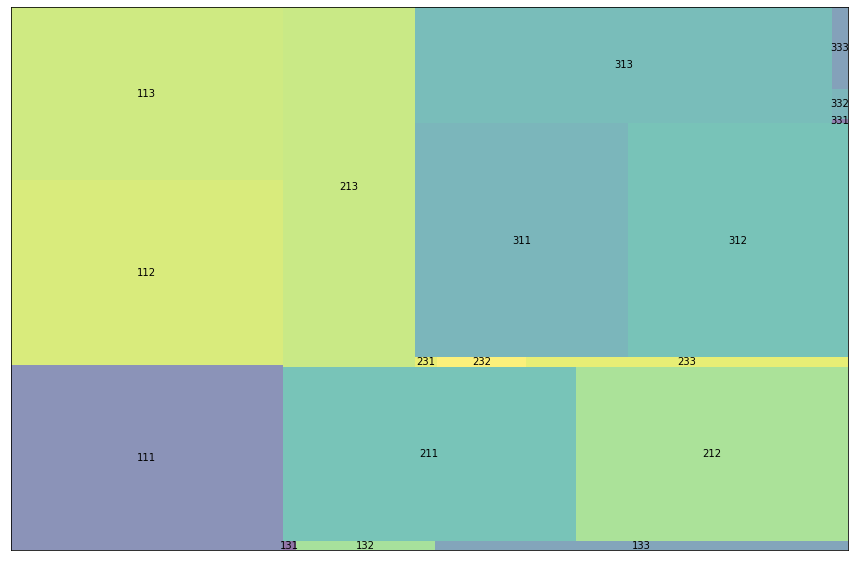

In [22]:
fig = plt.figure(figsize=(15, 10))
ax = squarify.plot(sizes=RFM_groups_size, label=RFM_groups_size.keys(), alpha=0.6 )
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

## 1.6 Conclusion  <a class="anchor" id="rfm_conclusion"></a> [⇪](#menu)

> #### Dans le cas présent, la méthode RFM ne semble pas adaptée.
> En effet, les scores de Fréquence sont difficile à découper en raison du trop grand nombre de clients qui ne font qu'un seul achat.<br>
> Il semble donc plus approprié de se diriger vers des méthodes de ségmentation non-supervisées telles que `KMeans`, `DBScan` ou le `Hierarchical Clustering`.

---
# 2. Feature Engineering <a class="anchor" id="fe"></a> [⇪](#menu)

>#### Nous avons vu avec la ségmentation RFM que si les variables `Recense` et `Montant` peuvent être utile au découpage des groupes, il n'en est pas de même pour la variable `Fréquence` que nous devons mettre de coté.

## 2.1 Regardons comment se répartissent nos clients avec ces deux seules variables...

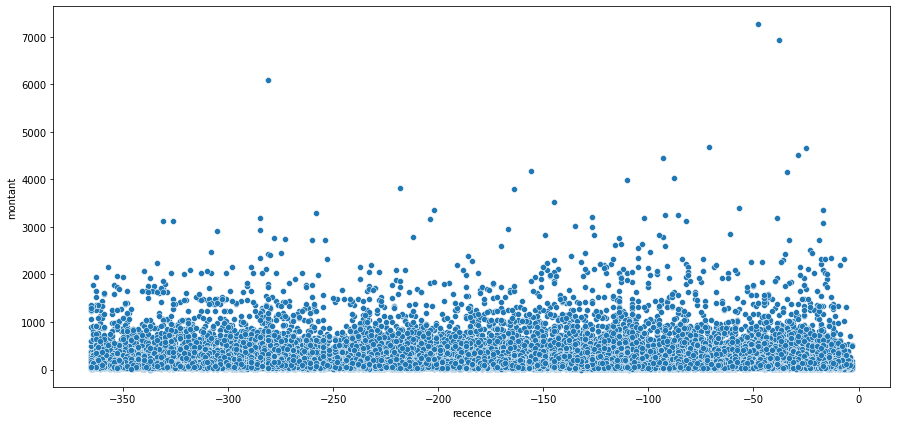

In [23]:
fig = plt.figure(figsize=(15, 7))
sns.scatterplot(x=RFM_data['recence'], y=RFM_data['montant'])
plt.show()

>#### Il va être difficile de ségmenter correctement avec seulement ces 2 variables
> *(le plus probable est de voir apparaitre une ségmentation sur les montants)*.
> 
> Il va donc falloir compléter le jeu de données avec plus de variables issues de nos 9 jeux de données initiaux, ou encore créer de nouvelles variables utiles.

## 2.2 Ajoutons des variables issues des autres jeux de données

#### Utilisons une table de référence qui nous permettra de faire les jointures sur toutes les tables utiles 

In [24]:
data_base_join = selection2[['order_id', 'customer_id', 'customer_unique_id']]
data_base_join.head(2)

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231


In [25]:
data_base_join.shape

(74213, 3)

In [26]:
data_clustering = data_base_join[['customer_unique_id']].merge(
        RFM_data[['customer_unique_id', 'recence', 'montant']],
        on='customer_unique_id', how='left'
    )
data_clustering.head(2)

,customer_unique_id,recence,montant
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82
1,af07308b275d755c9edb36a90c618231,-39,141.46


In [27]:
data_clustering.shape

(74213, 3)

### `olist_order_reviews_dataset.csv`
> ajoutons **les notes** données aux commandes par les clients et **le temps de réponse** à l'enquête de satisfaction.

#### Nous allons d'abord récupèrer ces variables `par commande`

In [28]:
data_fe1 = data_base_join.merge(
        data_reviews[['order_id', 'review_score', 'diff_dates']].groupby('order_id').last(), 
        on='order_id', how='left'
    )
data_fe1.shape

(74213, 5)

In [29]:
data_fe1.head(2)

,order_id,customer_id,customer_unique_id,review_score,diff_dates
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0,0.0


#### Puis en faire la moyenne `par client`

In [30]:
data_fe2 = data_fe1.groupby('customer_unique_id').mean().reset_index()
data_fe2.head(2)

,customer_unique_id,review_score,diff_dates
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,4.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,0.0


In [31]:
data_fe2.shape

(72247, 3)

#### On vérifie que l'on a pas perdu ou ajouté de lignes dans les jointures...

In [32]:
selection2.customer_unique_id.nunique()

72247

#### On applique les nouvelles valeurs sur le jeu de données `data_clustering`

In [33]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,diff_dates
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0


In [34]:
data_clustering.shape

(74213, 5)

### `olist_order_items_dataset.csv`
> ajoutons **le nombre moyen de produits** et le **le nombre total de produits** commandé par client

#### Nous allons d'abord récupèrer ces variables `par commande`

In [35]:
data_fe = data_items.groupby('order_id').last()[['order_item_id']].reset_index()
data_fe.head(2)

,order_id,order_item_id
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1


In [36]:
data_fe = data_base_join.merge(data_fe, on='order_id', how='left')
data_fe.head(2)

,order_id,customer_id,customer_unique_id,order_item_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,1


In [37]:
data_fe.shape

(74213, 4)

#### Puis en faire la moyenne `par client`

In [38]:
data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
data_fe2.rename(columns={'order_item_id': 'mean_items'}, inplace=True)
data_fe2.head(2)

,customer_unique_id,mean_items
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0


In [39]:
data_fe2.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_items,72247.0,1.141812,0.533297,1.0,1.0,1.0,1.0,20.0


In [40]:
data_fe3 = data_fe.groupby('customer_unique_id').sum().reset_index()
data_fe3.rename(columns={'order_item_id': 'total_items'}, inplace=True)
data_fe3.head(2)

,customer_unique_id,total_items
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1


In [41]:
data_fe3.describe().T

,count,mean,std,min,25%,50%,75%,max
total_items,72247.0,1.175647,0.616571,1.0,1.0,1.0,1.0,24.0


In [42]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering = data_clustering.merge(data_fe3, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,diff_dates,mean_items,total_items
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0,1.0,2
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0,1.0,1


In [43]:
data_clustering.shape

(74213, 7)

### `olist_orders_dataset.csv`
> ajoutons **le temps de livraison moyen** des commandes pour chaque client

#### Nous allons d'abord récupèrer ces variables `par commande`

In [44]:
data_fe = data_base_join.merge(
        data_orders[['order_id', 'delivery_days']].groupby('order_id').last(), 
        on='order_id', how='left'
)
data_fe.head(2)

,order_id,customer_id,customer_unique_id,delivery_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,14.0


In [45]:
data_fe.shape

(74213, 4)

#### Puis en faire la moyenne `par client`

In [46]:
data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
data_fe2.head(2)

,customer_unique_id,delivery_days
0,0000366f3b9a7992bf8c76cfdf3221e2,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3.0


In [47]:
data_fe2.shape

(72247, 2)

#### On applique les nouvelles valeurs sur le jeu de données `data_clustering`

In [48]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,diff_dates,mean_items,total_items,delivery_days
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0,1.0,2,4.5
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0,1.0,1,14.0


In [49]:
data_clustering.shape

(74213, 8)

In [50]:
X_cluster = data_clustering[[*data_clustering.select_dtypes(include='number')]].copy()
X_cluster.head(2)

,recence,montant,review_score,diff_dates,mean_items,total_items,delivery_days
0,-362,82.82,4.5,1.0,1.0,2,4.5
1,-39,141.46,4.0,0.0,1.0,1,14.0


In [51]:
X_cluster.shape

(74213, 7)

In [52]:
X_cluster.isnull().mean()

recence          0.000000
montant          0.000000
review_score     0.006158
diff_dates       0.006158
mean_items       0.000000
total_items      0.000000
delivery_days    0.000094
dtype: float64

In [53]:
X_cluster.dropna(inplace=True)

In [54]:
X_cluster.isnull().mean()

recence          0.0
montant          0.0
review_score     0.0
diff_dates       0.0
mean_items       0.0
total_items      0.0
delivery_days    0.0
dtype: float64

In [55]:
X_cluster.shape

(73749, 7)

In [56]:
from sklearn.preprocessing import MinMaxScaler #, LabelEncoder, OneHotEncoder, OrdinalEncoder,

In [57]:
def fit_normalizer(data):
    """ Normalize the values of the provided dataset
        
    Parameters
    ----------
    data: pandas' DataFrame
        the dataset used as reference for the scaler
        
    Returns
    -------
    MinMaxScaler
        the scaler instance
    """
       
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    return scaler

def normalize(data, robust_scaler):
    """ Transform the provided dataset using the provided scaler.
            
    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    robust_scaler: MinMaxScaler 
        the scaler instance to apply on the dataset
        
    Returns
    -------
    DataFrame
        a new dataframe with the sclaed values
    """
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [58]:
model_scaler = fit_normalizer(X_cluster)
X_cluster_norm = normalize(X_cluster, model_scaler)

In [59]:
X_cluster_norm.head(2)

,recence,montant,review_score,diff_dates,mean_items,total_items,delivery_days
0,0.008287,0.011384,0.875,0.002874,0.0,0.043478,0.016908
1,0.900552,0.019445,0.750,0.000000,0.0,0.000000,0.062802


In [60]:
X_sample = X_cluster_norm.sample(frac=0.25, random_state=random_seed).reset_index(drop=True).copy()

---
# 2. Apprentissage non-supervisé *(sans optimisation*)  <a class="anchor" id="unsupervised"></a> [⇪](#menu)

- 🚩 ICI on parle de l'apprentisage suppervisé 
- 🚩 ICI on explique que l'on a pas besoin de train/validation/test split
> La plupart des algorithmes de clustering ne peuvent pas "prédire" pour de nouvelles données. K-means est une rare exception, car vous pouvez effectuer une classification par plus proche voisin sur les centroïdes pour prédire. Mais pour toute méthode qui n'utilise pas les centroïdes, on ne voit pas très bien comment on pourrait appliquer cela à des données "test".
- 🚩 ICI on parle de la metric utilisé dans le cadre du clustering --> silhouette (ses avantages, ses défauts, ses bornes -1/+1 etc.)

### Définissons la métrique utilisée par la fonction de recherche des hyper-paramètres

In [61]:
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples

In [62]:
def cv_silhouette_scorer(estimator, X_ref):
    estimator.fit(X_ref)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X_ref.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X_ref, cluster_labels)

### Définissons des fonctions pour afficher et enregistrer les scores

In [63]:
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance

In [64]:
scores_df = pd.DataFrame(columns=['Method', 'params', 'best_params', 'silhouette', 'Training time', 'Inference time'])
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)


def get_clustering_scores(method_name, model, X_ref=None, param_grid=None, best_params=None, training_time=None, inference_time=None, register=False, **others):
    """ Compute / Display / Save scores for the provided model

    More precisely, it compute the scores then call various function to display and save them.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    model: 
        the model that needs to be evaluated
    X_ref: list of lists
        the X values used to get the predictions
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    """

    if X_ref is None:
        X_ref = X_cluster

    scores = {
        'silhouette': cv_silhouette_scorer(model, X_ref),
    }

    # Register score and replace if it already exists
    if register:
        save_score(method_name, param_grid, best_params, training_time, inference_time, **scores)

    # Basic report
    scores_str = ""
    for key in scores.keys():
        scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"

    print(f"--- {method_name} ---".ljust(100, '-'), "\n\n", scores_str, sep="")

    # Silhouette plot
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    visualizer.fit(X_ref)
    visualizer.show();

In [65]:
def save_score(method_name, param_grid, best_params, training_time, inference_time, **scores):
    """ Save the scores into the 'scores_df' DataFrame and to the 'scores_path' CSV file.
    Each call to this function appends exactly one row to the DataFrame and hence to the CSV.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    scores: list of parameters
        the scores to register
    """

    idx = np.where(scores_df.Method == method_name)[0]
    idx = idx[0] if idx.size > 0 else len(scores_df.index)

    silhouette = scores.get('silhouette', None)

    scores_df.loc[idx] = [method_name, param_grid, best_params, silhouette, training_time, inference_time]
    scores_df.to_csv(scores_path, index=False)

### Définissons une function de recherche des hyper-parametres avec cross-validation

In [66]:
from sklearn.experimental import enable_halving_search_cv
#from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # --> GridSearchCV trop lent


def fit_clustering_model(model, X_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2):
    """ Search the best hyper-parameters for the provided model

    Parameters
    ----------
    model: 
        the model that needs to make predictions
    X_ref: list of lists
        the X values used to get the predictions
    param_grid: dict
        the parameter grid used to get the provided scores
    scoring: str
        the scoring method to use when evaluating the model in the Grid Search CV process
    cv: int / CrossValidation
        the number of cross validations to apply OR the instance of a CrossValidation instance
    verbose: int
        defines how much details are printed while training the model
        0 : nothing
        1 : K-fold scores + results for test set
        2 : K-fold scores + results for test & train sets

    Returns
    -------
    dict
        a dictionnary containing:
        - grid: the grid search instance 
        - model: the grid search best estimator
        - training_time: the fitting time
        - inference_time: the prediction time
        - param_grid: the parameters used for the grid search
    """

    if X_ref is None:
        X_ref = X_cluster

    fit_time = time.perf_counter()
    #grid_model = RandomizedSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, random_state=random_seed)#, refit=refit_scoring)
    #grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=0)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    
    grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0)
    grid_model.fit(X_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_

    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]

    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print("".center(100, '-'))

            for sample in sets_list:
                scores_str = f"{str(scoring).upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")

    # Print overall scores
    if verbose > 0:

        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{str(scoring).upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")

        print("\n", "".center(100, '-'), sep='')

    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()

    return {
        'grid': grid_model,
        'model': grid_model.best_estimator_,
        'training_time': fit_time,
        'inference_time': inf_time,
        'param_grid': param_grid,
        'best_params': grid_model.best_params_
    }

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Comme on a des algorithmes qui utilisent les distances, il est préférable de **normaliser les données** !

## 2.1 K-Means <a class="anchor" id="kmeans"></a> [⇪](#menu)

Le K-means clustering *(ou segmentation par K-moyennes)* est une technique qui vise à partitionner *n* observations en *k* clusters dans lesquels chaque observation appartient au cluster dont la moyenne est la plus proche. 

In [67]:
from sklearn.cluster import KMeans

### 2.1 Basic Kmeans
Commençons par regarder comment se comporte le K-means avec les données que nous avons déjà *(hors Fréquence puisque l'on a vu que c'est une donnée peu pertinente avec seulement 3% des clients qui achètent plus d'une fois)*, et sans recherche des hyper-paramètres.

In [68]:
param_grid_kmeans = [
    {
        'random_state': [random_seed],
        # 'n_clusters':[3,4,5,6,7,8,9],
    }
]

In [69]:
kmeans = KMeans()
grd_kmeans = fit_clustering_model(
    kmeans,
    param_grid=param_grid_kmeans,  
    X_ref=X_sample[['recence', 'montant']],
    cv=3,
    scoring=cv_silhouette_scorer
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.5082
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.5100
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.5140

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.5083 (std:0.0047)

----------------------------------------------------------------------------------------------------


In [70]:
grd_kmeans['grid'].best_params_

{'random_state': 0}

--- KMeans [basic] ---------------------------------------------------------------------------------

          SILHOUETTE : 0.5080



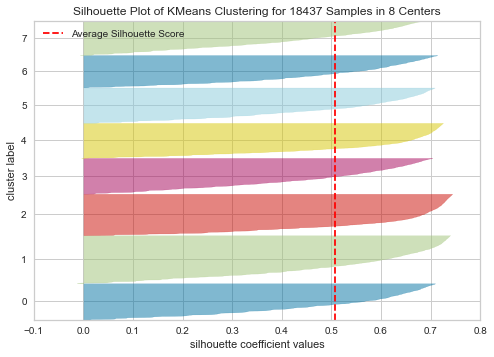

In [71]:
model_name = "KMeans"
get_clustering_scores(f"{model_name} [basic]", X_ref=X_sample[['recence', 'montant']], **grd_kmeans, register=True)

### 2.2 KMeans + Feature Engineering

In [72]:
X_sample.columns

Index(['recence', 'montant', 'review_score', 'diff_dates', 'mean_items',
       'total_items', 'delivery_days'],
      dtype='object')

In [73]:
kmeans = KMeans()
grd_kmeans = fit_clustering_model(
    kmeans,
    param_grid=param_grid_kmeans,
    X_ref=X_sample,
    cv=3,
    scoring=cv_silhouette_scorer
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.3997
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4357
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4283

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4232 (std:0.0126)

----------------------------------------------------------------------------------------------------


In [74]:
grd_kmeans['grid'].best_params_

{'random_state': 0}

--- KMeans [fe] ------------------------------------------------------------------------------------

          SILHOUETTE : 0.4285



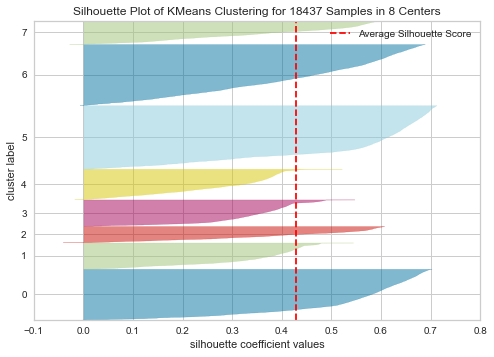

In [75]:
model_name = "KMeans"
get_clustering_scores(f"{model_name} [fe]", X_ref=X_sample, **grd_kmeans, register=True)

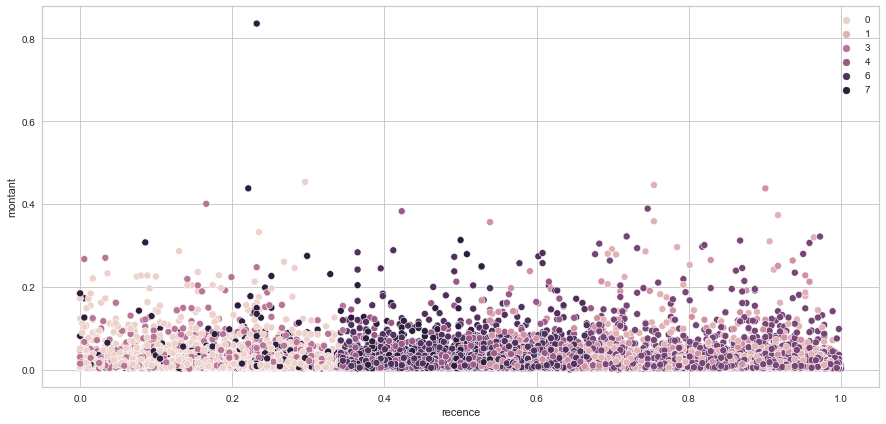

In [76]:
fig = plt.figure(figsize=(15,7))
sns.scatterplot(x=X_sample['recence'], y=X_sample['montant'], hue=grd_kmeans['model'].labels_)
plt.show()

### 2.3 KMeans + Elbow

In [77]:
from yellowbrick.cluster import KElbowVisualizer

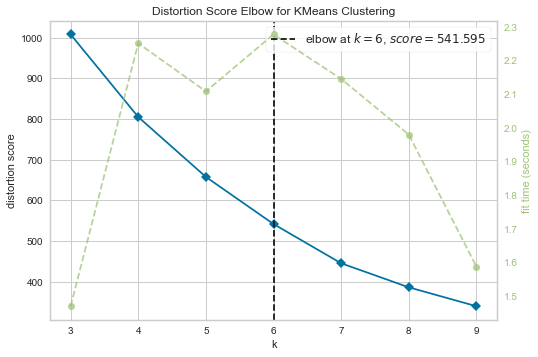

In [78]:
visualizer = KElbowVisualizer(kmeans, k=(3, 10))
visualizer.fit(X_sample)
visualizer.show();

#### Regardons ce que donne une KMeans avec 6 clusters

In [79]:
param_grid_kmeans = [
    {
        'random_state': [random_seed],
        'n_clusters':[6],
    }
]

In [80]:
kmeans = KMeans()
grd_kmeans = fit_clustering_model(
    kmeans,
    param_grid=param_grid_kmeans,
    X_ref=X_sample,
    cv=3,
    scoring=cv_silhouette_scorer
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4261
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4284
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4216

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4242 (std:0.0044)

----------------------------------------------------------------------------------------------------


In [81]:
grd_kmeans['grid'].best_params_

{'n_clusters': 6, 'random_state': 0}

--- KMeans [fe+elbow] ------------------------------------------------------------------------------

          SILHOUETTE : 0.4219



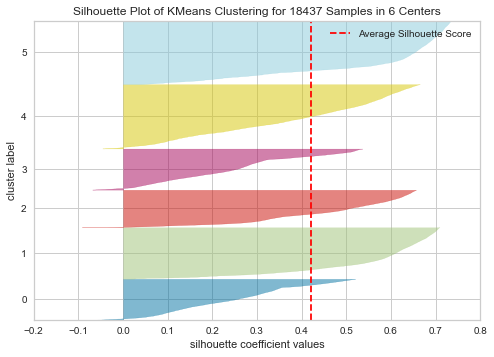

In [82]:
model_name = "KMeans"
get_clustering_scores(f"{model_name} [fe+elbow]", X_ref=X_sample, **grd_kmeans, register=True)

### 2.4 Kmeans with Grid search

In [83]:
param_grid_kmeans = [
    {
        'random_state': [random_seed],
        'n_clusters':range(3, 10),
    }
]

In [84]:
kmeans = KMeans()
grd_kmeans = fit_clustering_model(
    kmeans,
    param_grid=param_grid_kmeans,
    X_ref=X_sample,
    cv=3,
    scoring=cv_silhouette_scorer
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4279
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4374
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4338

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- <FUNCTION CV_SILHOUETTE_SCORER AT 0X7F24536A4310>: 0.4327 (std:0.0059)

----------------------------------------------------------------------------------------------------


In [85]:
grd_kmeans['grid'].best_params_

{'n_clusters': 3, 'random_state': 0}

--- KMeans [fe+grid] -------------------------------------------------------------------------------

          SILHOUETTE : 0.4687



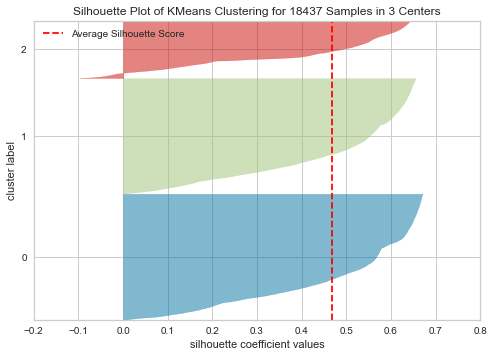

In [86]:
model_name = "KMeans"
get_clustering_scores(f"{model_name} [fe+grid]", X_ref=X_sample, **grd_kmeans, register=True)

In [87]:
X_labels = pd.DataFrame(grd_kmeans['model'].labels_, columns=['label'])

In [88]:
X_results = X_sample.merge(X_labels, left_index=True, right_index=True)

In [89]:
X_results

,recence,montant,review_score,diff_dates,mean_items,total_items,delivery_days,label
0,0.372928,0.013336,0.75,0.000000,0.000000,0.000000,0.106280,1
1,0.676796,0.054181,1.00,0.000000,0.000000,0.000000,0.028986,0
2,0.182320,0.227785,1.00,0.000000,0.000000,0.000000,0.077295,1
3,0.201657,0.025111,1.00,0.005747,0.000000,0.000000,0.033816,1
4,0.273481,0.011854,1.00,0.017241,0.000000,0.000000,0.115942,1
...,...,...,...,...,...,...,...,...
18432,0.069061,0.012891,1.00,0.008621,0.000000,0.000000,0.028986,1
18433,0.187845,0.004538,1.00,0.000000,0.000000,0.000000,0.038647,1
18434,0.245856,0.026803,0.00,0.008621,0.026316,0.086957,0.021739,2
18435,0.450276,0.014690,1.00,0.000000,0.000000,0.000000,0.086957,1


In [90]:
lab0 = X_results[X_results.label == 0]
lab1 = X_results[X_results.label == 1]
lab2 = X_results[X_results.label == 2]

In [91]:
lab0.mean()

recence          0.760505
montant          0.022206
review_score     0.923396
diff_dates       0.006403
mean_items       0.006051
total_items      0.006888
delivery_days    0.041307
label            0.000000
dtype: float64

In [92]:
lab1.mean()

recence          0.267841
montant          0.022941
review_score     0.921424
diff_dates       0.007538
mean_items       0.005618
total_items      0.009657
delivery_days    0.056228
label            1.000000
dtype: float64

In [93]:
lab2.mean()

recence          0.485181
montant          0.026294
review_score     0.194464
diff_dates       0.006405
mean_items       0.015127
total_items      0.015965
delivery_days    0.089041
label            2.000000
dtype: float64

In [94]:
import math

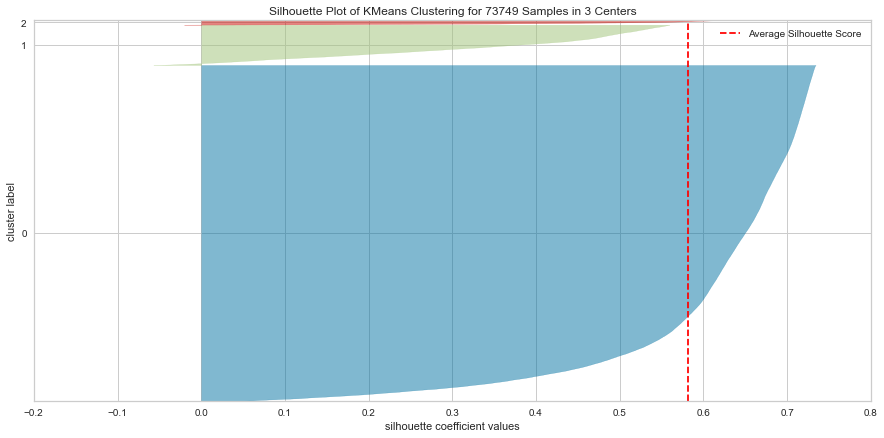

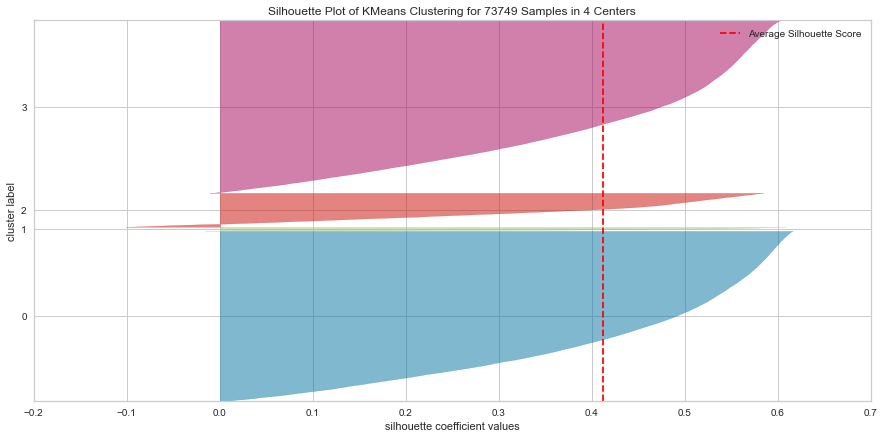

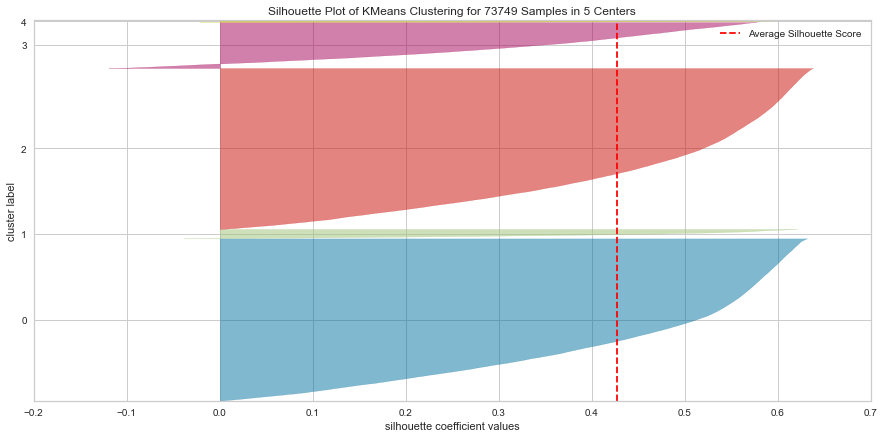

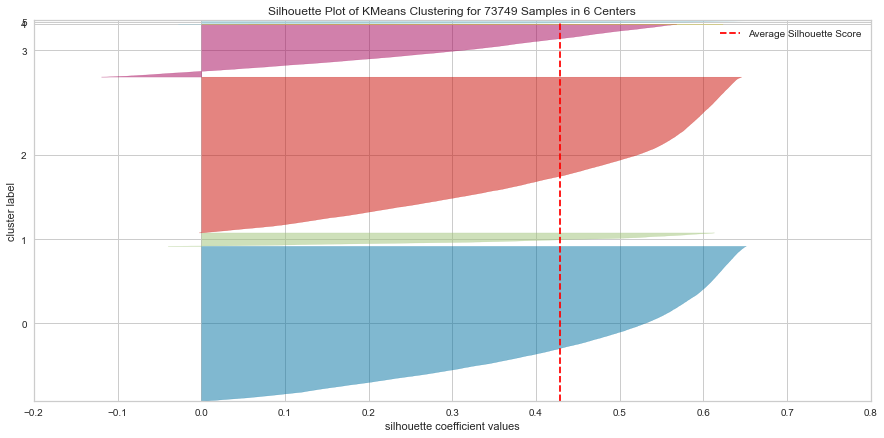

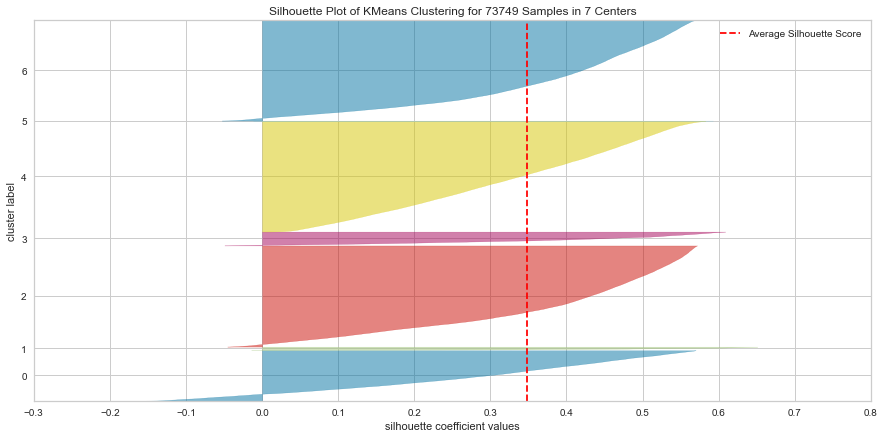

In [95]:
k_range = range(3,8)
k_size = len(k_range)
# fig = plt.figure(figsize=(15,7*k_size))

for i, j in enumerate(k_range):
    # ax = plt.subplot(k_size,1,i+1)
    fig = plt.figure(figsize=(15,7))
    plt.title(f"KMeans with {j} clusters")
    model = KMeans(n_clusters=j, random_state=0)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X_cluster)
    # plt.show()
    visualizer.show();
# plt.show()

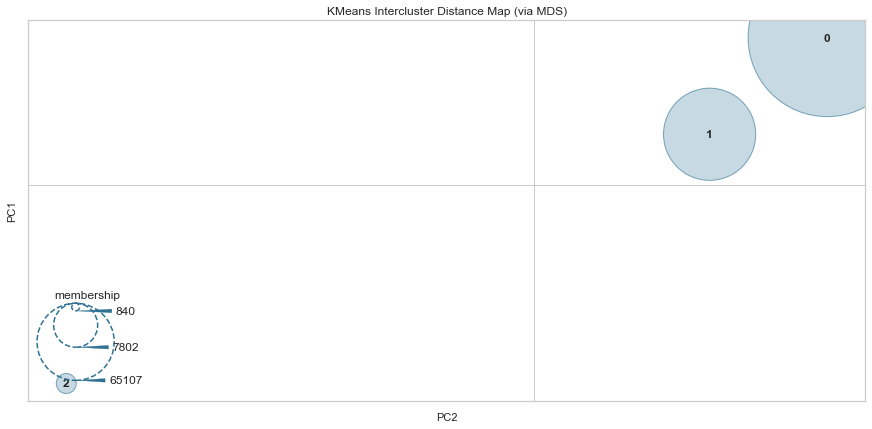

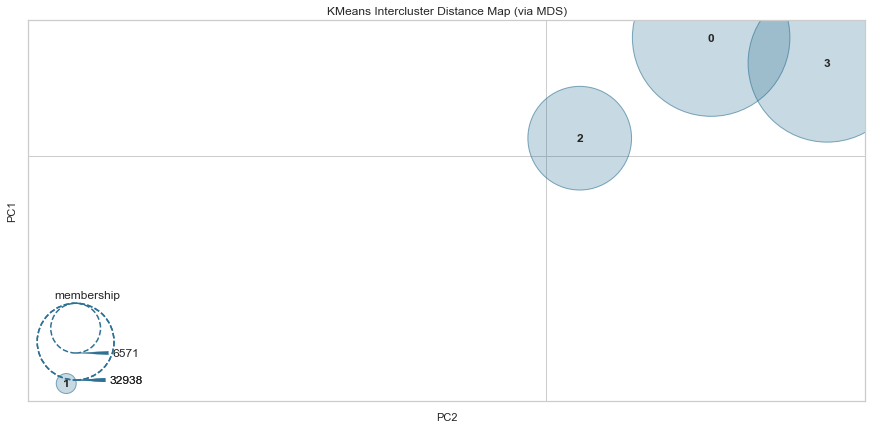

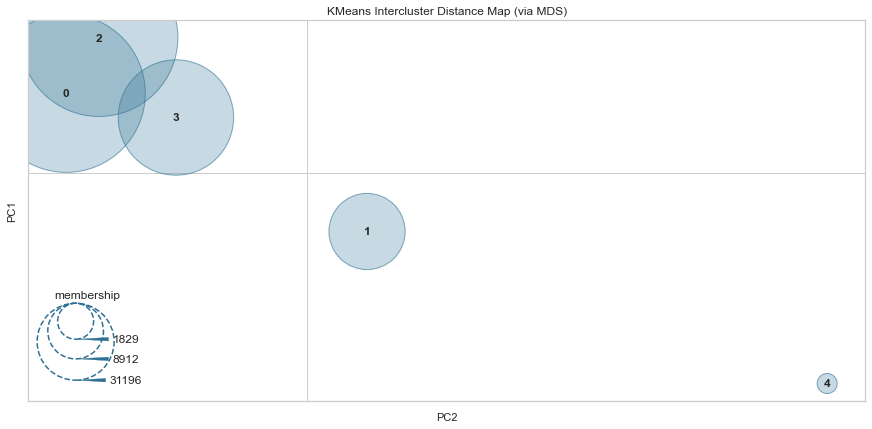

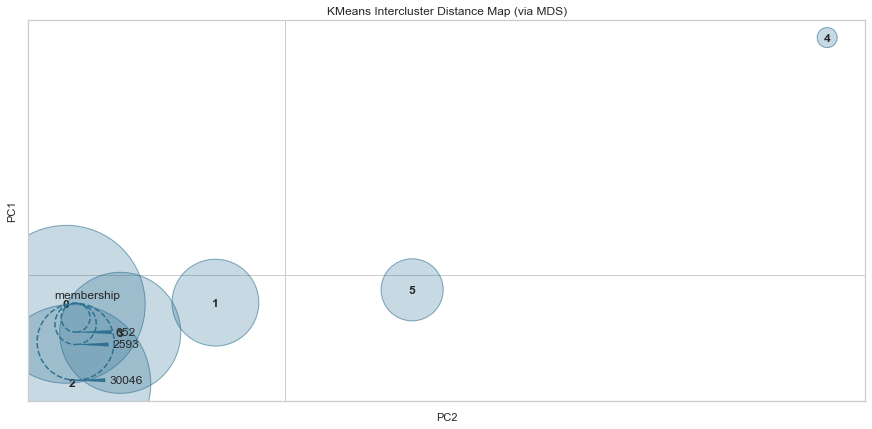

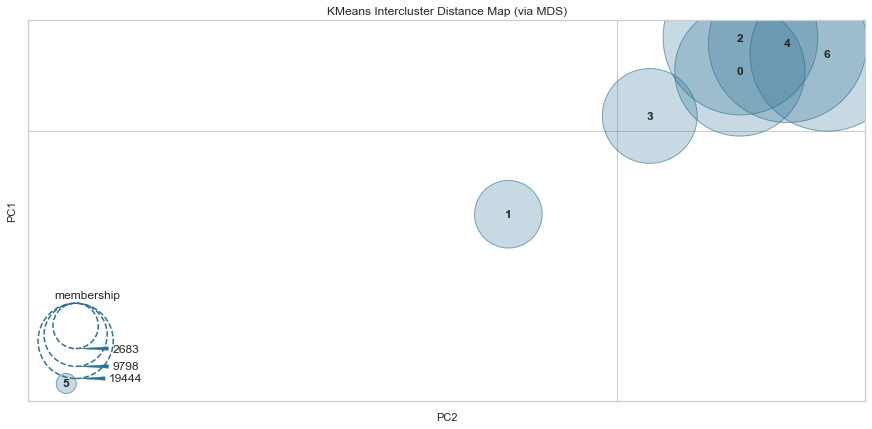

In [96]:
for j in range(3, 8):
    fig = plt.figure(figsize=(15,7))
    plt.title(f"KMeans with {j} clusters")
    model = KMeans(n_clusters=j, random_state=0)
    visualizer = InterclusterDistance(model, colors='yellowbrick')
    visualizer.fit(X_cluster)
    visualizer.show();

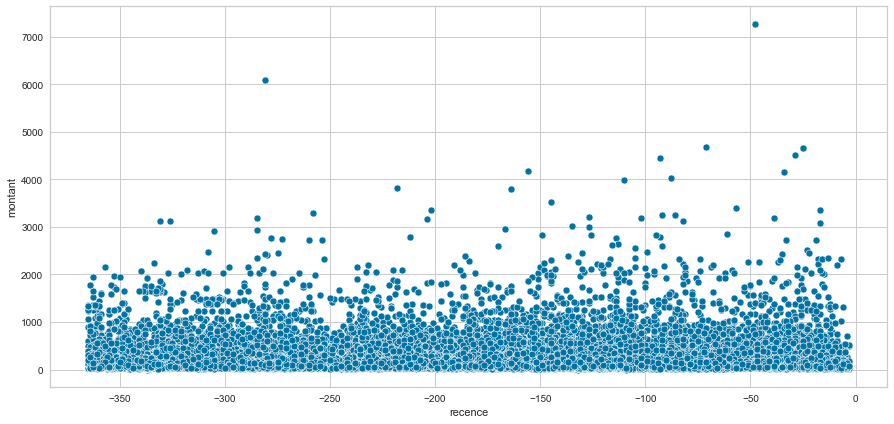

In [97]:
fig = plt.figure(figsize=(15, 7))
sns.scatterplot(x=X_cluster['recence'], y=X_cluster['montant'])
plt.show()

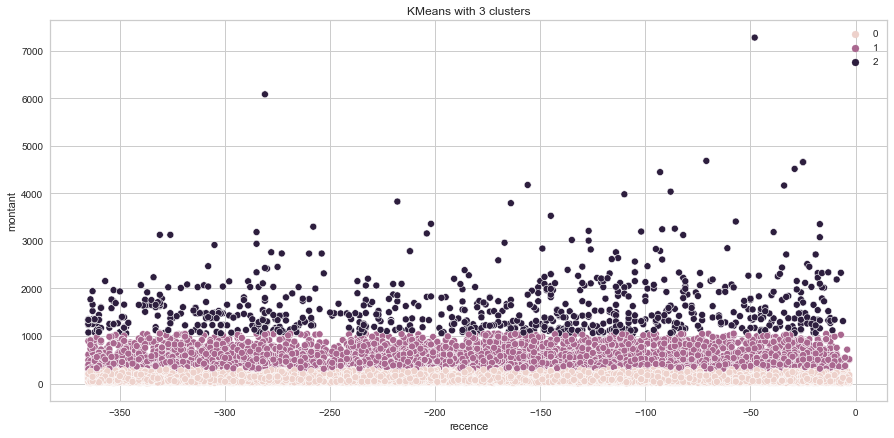

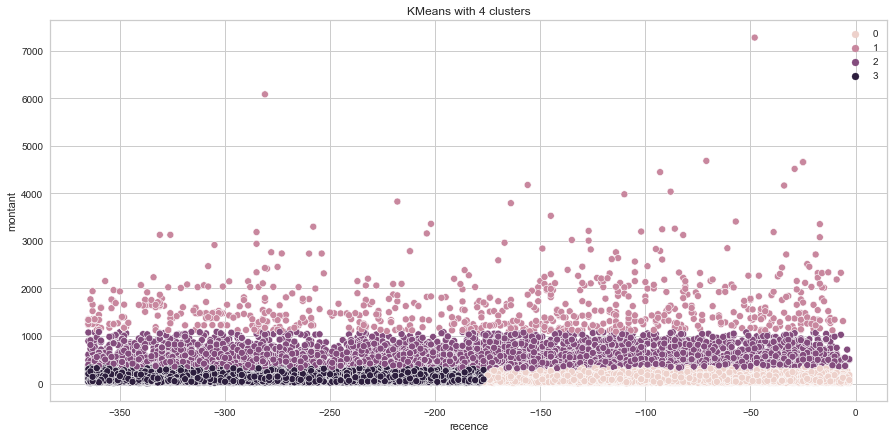

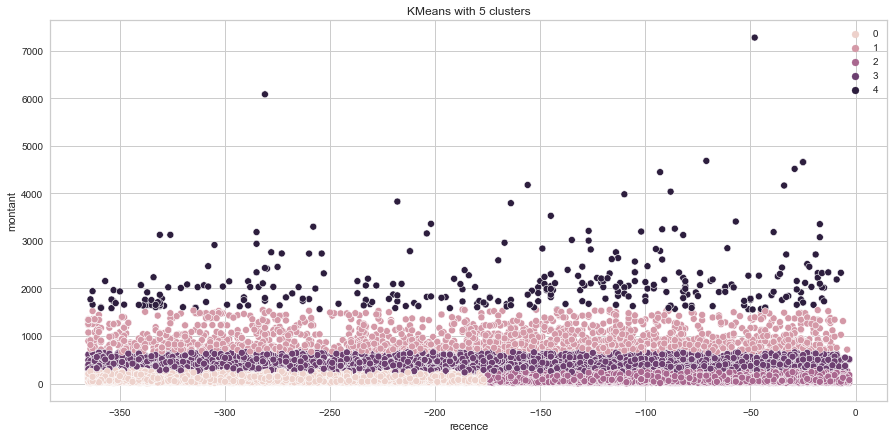

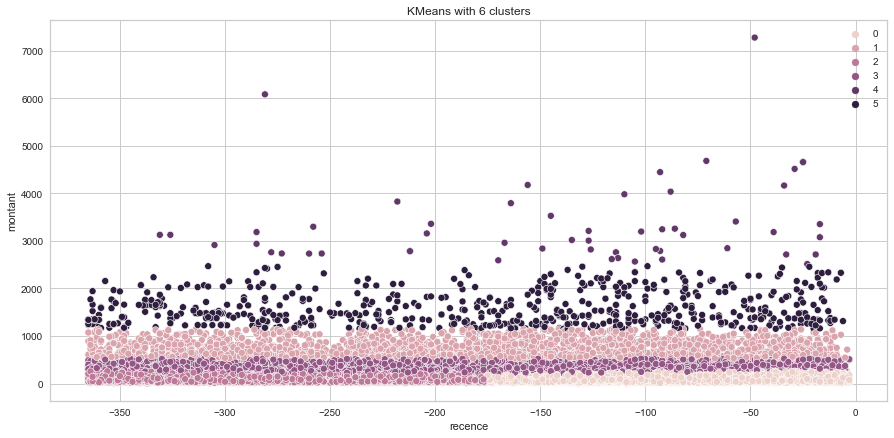

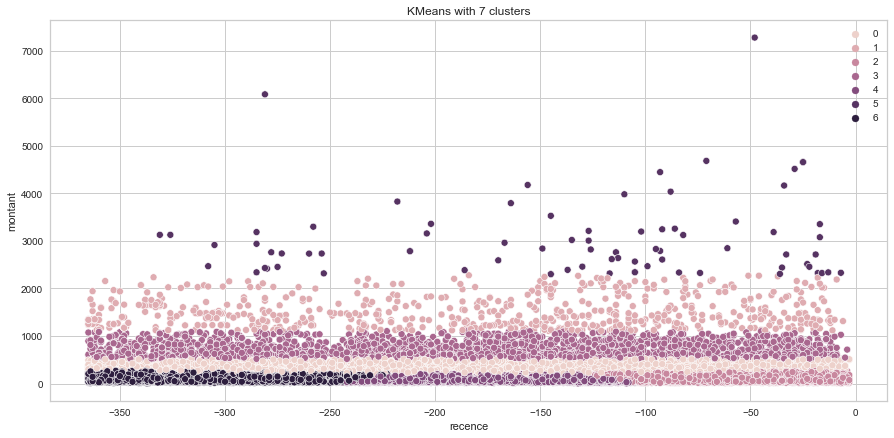

In [98]:
k_range = range(3, 8)
k_size = len(k_range)
for i, j in enumerate(k_range):
    model = KMeans(n_clusters=j, random_state=0)
    model.fit(X_cluster)

    fig = plt.figure(figsize=(15, 7))
    plt.title(f"KMeans with {j} clusters")
    sns.scatterplot(x=X_cluster['recence'], y=X_cluster['montant'], hue=model.labels_)
    plt.show()